# Group Project
### Members:
- Minh Au
- Andrew Carriere
- Veronika Bumbulovic
- Kevin Yoon Jeong

## 1. Introduction
Heart disease is the second leading cause of death in Canada after cancer(1). The cause of heart disease is multifactorial and has been linked to smoking, dyslipidemia, hypertension, diabetes, obesity, and lifestyle (2). Heart disease refers to the following 4 pathologies(2):

- Coronary heart disease (CHD): Caused by ischemia (lack of oxygen perfusion) of myocardial tissues resulting in angina, myocardial infarction and/or heart failure.
- Cerebrovascular diseases: This includes stroke and transient ischemic attack.
- Peripheral artery disease (PAD): Arterial disease occurring in peripheral tissues causing ischemia.
- Aortic arteriosclerosis: Narrowing and stiffening of aorta that can result in aneurysm. 


In this project, we will explore how some factors impact the likelihood of developing heart disease. The dataset was sourced from the UC Irvine Machine Learning Repository, and Andras Janosi, M.D., at the Hungarian Institute of Cardiology, collected the data. 

## 1.2 Preliminary exploratory data analysis
The following two cells will load necessary libraries and read in the data which is nescessary as the first step for the analysis.

In [103]:
library(tidyverse)
library(repr)
library(tidymodels)
library(patchwork)
library(RColorBrewer)

To populate the dataset, data from Hungary, Long beach, and Switzerland, will be combined into one. We are excluding the data from Cleveland because according to the README, the file containing the data is corrupted.

In [13]:
# Reading the data
hungarian_heart_data <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/hungarian.data", col_names = FALSE)
longbeach_heart_data <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/long-beach-va.data", col_names = FALSE)
switzerland_heart_data <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/switzerland.data", col_names = FALSE)
# Combine multiple data sets into one
heart_data <- rbind(hungarian_heart_data, longbeach_heart_data) |>
    rbind(switzerland_heart_data)
head(heart_data, 10)

Rows: 2940 Columns: 1
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): X1

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2000 Columns: 1
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): X1

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1230 Columns: 1
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): X1

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


X1
<chr>
1254 0 40 1 1 0 0
-9 2 140 0 289 -9 -9 -9
0 -9 -9 0 12 16 84 0
0 0 0 0 150 18 -9 7
172 86 200 110 140 86 0 0
0 -9 26 20 -9 -9 -9 -9
-9 -9 -9 -9 -9 -9 -9 12
20 84 0 -9 -9 -9 -9 -9
-9 -9 -9 -9 -9 1 1 1


As seen in the small subset above, the data is not in tidy format and thus, is not ready for analysis. From the documentations, we know that there are 76 attributes, but currently, they are all grouped in one column. Furthermore, the 76 attributes are spread across 10 different lines with different number of attributes on each line (some with 7 while the others only have 8). As such, the data wrangling strategy is as follows:

    1. Combine the 76 attributes into one row. They need to be separated by a specific delimiter such as ",".
    2. Each rows are separated out into multiple columns.
    3. Load the names of the attributes
    4. Select the following factors as decribed in the method section and convert them into correct type
         - age - age in years
         - sex - 0 for female, 1 for male
         - chol - serum cholestoral in mg/dl
         - cigs - cigarettes per day
         - years - number of years as a smoker
         - thalach - maximum heart rate achieved
         - thalrest - resting heart rate
         - trestbpd - resting blood pressure
         - num - diagnosis of heart disease (0 for absence, 1 - 4 for present)

In [14]:
# Separate the data with commas
separated_with_commas <- heart_data |>
    separate(col = X1, into = c("X1", "X2", "X3", "X4", "X6", "X7", "X8", "X9"), sep = " ") |>
    rowwise() |>
    mutate(combined_col = paste0(str_replace_na(c_across(X1:X9), replacement = ""), collapse = ",")) |>
    ungroup() |>
    select(combined_col)

Warning message:
“Expected 8 pieces. Missing pieces filled with `NA` in 1234 rows [1, 10, 11, 20, 21, 30, 31, 40, 41, 50, 51, 60, 61, 70, 71, 80, 81, 90, 91, 100, ...].”


In [24]:
# Combine rows and split columns before assigning names
clean_data <- separated_with_commas |>
    mutate(num = ceiling(row_number() / 10)) |>
    group_by(num) |>
    summarise(combined_col = gsub(',,', ',', gsub('NA', '', paste0(combined_col, collapse = ",")))) |>
    ungroup() |>
    separate(col = combined_col, into = c('id', 'ccf', 'age', 'sex', 'painloc', 'painexer', 'relrest', 'pncaden', 'cp', 'trestbps', 'htn', 'chol', 'smoke', 'cigs', 'years', 'fbs', 'dm', 'famhist', 'restecg', 'ekgmo', 'ekgday', 'ekgyr', 'dig', 'prop', 'nitr', 'pro', 'diuretic', 'proto', 'thaldur', 'thaltime', 'met', 'thalach', 'thalrest', 'tpeakbps', 'tpeakbpd', 'dummy', 'trestbpd', 'exang', 'xhypo', 'oldpeak', 'slope', 'rldv5', 'rldv5e', 'ca', 'restckm', 'exerckm', 'restef', 'restwm', 'exeref', 'exerwm', 'thal', 'thalsev', 'thalpul', 'earlobe', 'cmo', 'cday', 'cyr', 'num', 'lmt', 'ladprox', 'laddist', 'diag', 'cxmain', 'ramus', 'om1', 'om2', 'rcaprox', 'rcadist', 'lvx1', 'lvx2', 'lvx3', 'lvx4', 'lvf', 'cathef', 'junk', 'name'), sep = ",")
head(clean_data, 1)
# Convert the types of the data and select desired factors
processed_heart_data <- clean_data |>
    select(age, sex, chol, cigs, years, thalach, thalrest, trestbpd, num) |>
    mutate(age = as.numeric(age), sex = as.numeric(sex), chol = as.numeric(chol), cigs = as.numeric(cigs), 
          years = as.numeric(years), thalach = as.numeric(thalach), thalrest = as.numeric(thalrest), 
           trestbpd = as.numeric(trestbpd), num = as.numeric(num))
head(processed_heart_data, 5)

Warning message:
“Expected 76 pieces. Additional pieces discarded in 617 rows [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, ...].”


id,ccf,age,sex,painloc,painexer,relrest,pncaden,cp,trestbps,⋯,rcaprox,rcadist,lvx1,lvx2,lvx3,lvx4,lvf,cathef,junk,name
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1254,0,40,1,1,0,0,-9,2,140,⋯,-9,-9,1,1,1,1,1,-9.,-9.,name


age,sex,chol,cigs,years,thalach,thalrest,trestbpd,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
40,1,289,-9,-9,172,86,86,0
49,0,180,-9,-9,156,100,90,1
37,1,283,-9,-9,98,58,80,0
48,0,214,-9,-9,108,54,86,3
54,1,-9,-9,-9,122,74,90,0


Note that sex is not converted into factor because the model can only classify using numeric predictors. Having sex as numeric will not affect the scaling or the training in any detrimental way because it is a simple binary category. <br>
Most of the smoking data is missing (-9 represents missing data), so it cannot be used for training the model. <br>
Also, a heart disease diagnosis is a binary category since it's either present or absent. So it's represented as 0 and 1 being the absence or presence of the heart disease, respectively. For clarity, let the column name be "diagnosis." <br>

In [25]:
# Remove unwanted factors and add NA
final_heart_data <- processed_heart_data |>
    mutate(diagnosis = 1 * (num >= 1)) |>
    mutate(diagnosis = as_factor(diagnosis)) |>
    select(-cigs, -years, -num)
final_heart_data[final_heart_data == -9] <- NA
final_heart_data <- final_heart_data |>
    drop_na()
head(final_heart_data)

age,sex,chol,thalach,thalrest,trestbpd,diagnosis
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
40,1,289,172,86,86,0
49,0,180,156,100,90,1
37,1,283,98,58,80,0
48,0,214,108,54,86,1
39,1,339,170,86,80,0
45,0,237,170,90,84,0


As a result, the table above shows a subset of the wrangled data. Now, we can split the data into training and testing sets to begin the analysis. Since there are 531 rows of data, 80% of the dataset will give us approximately 430 observations which is suitable to train the model. Therefore, the proportion between training data and testing data will be 80%.

In [26]:
# Splitting the data into training and testing
set.seed(1337) # Set seed for reproducility
heart_split <- initial_split(final_heart_data, prop = 0.8, strata = diagnosis)
heart_train <- training(heart_split)
heart_test <- testing (heart_split)

Now, let's examine training set for more information about the data. One useful data is the number of observations with heart disease and that without.

In [27]:
# Summarize the training data
heart_train |>
    group_by(diagnosis) |>
    summarize(count = n())

diagnosis,count
<fct>,<int>
0,167
1,257


As seen with the summary table, the number of people with heart disease differs those without by approximately 100 people. This is a significant amount, considering the size of the training set. Thus, it will be taken into account when the actual classification is done.

Calculating the means after grouping by the presence of heart disease and sex will highlight the difference between the two sex in the context of heart diseases.

In [28]:
# Summarize the training data
heart_train |>
    group_by(diagnosis, sex) |>
    summarise(count = n(), mean_age = mean(age, na.rm = TRUE), mean_chol = mean(chol, na.rm = TRUE),
             mean_thalach = mean(thalach, na.rm = TRUE), mean_thalrest = mean(thalrest, na.rm = TRUE),
             mean_trestbpd = mean(trestbpd, na.rm = TRUE))

`summarise()` has grouped output by 'diagnosis'. You can override using the
`.groups` argument.


diagnosis,sex,count,mean_age,mean_chol,mean_thalach,mean_thalrest,mean_trestbpd
<fct>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,0,53,47.81132,245.6981,142.3019,81.00000,82.01887
0,1,114,48.60526,203.1404,141.7018,80.42982,83.86842
1,0,16,54.50000,176.7500,131.2500,85.62500,86.37500
1,1,241,55.37344,135.6680,123.0830,71.80913,82.65560


Looking at the table, it could be seen that there are more men who have heart diseases than women. Moreover, it generally requires women to have higher health statistics to have heart conditions (except for age). For both sex, people with heart diseases are generally older than those without, according to the mean.

## 1.3 Visualization of Preliminary exploratory data

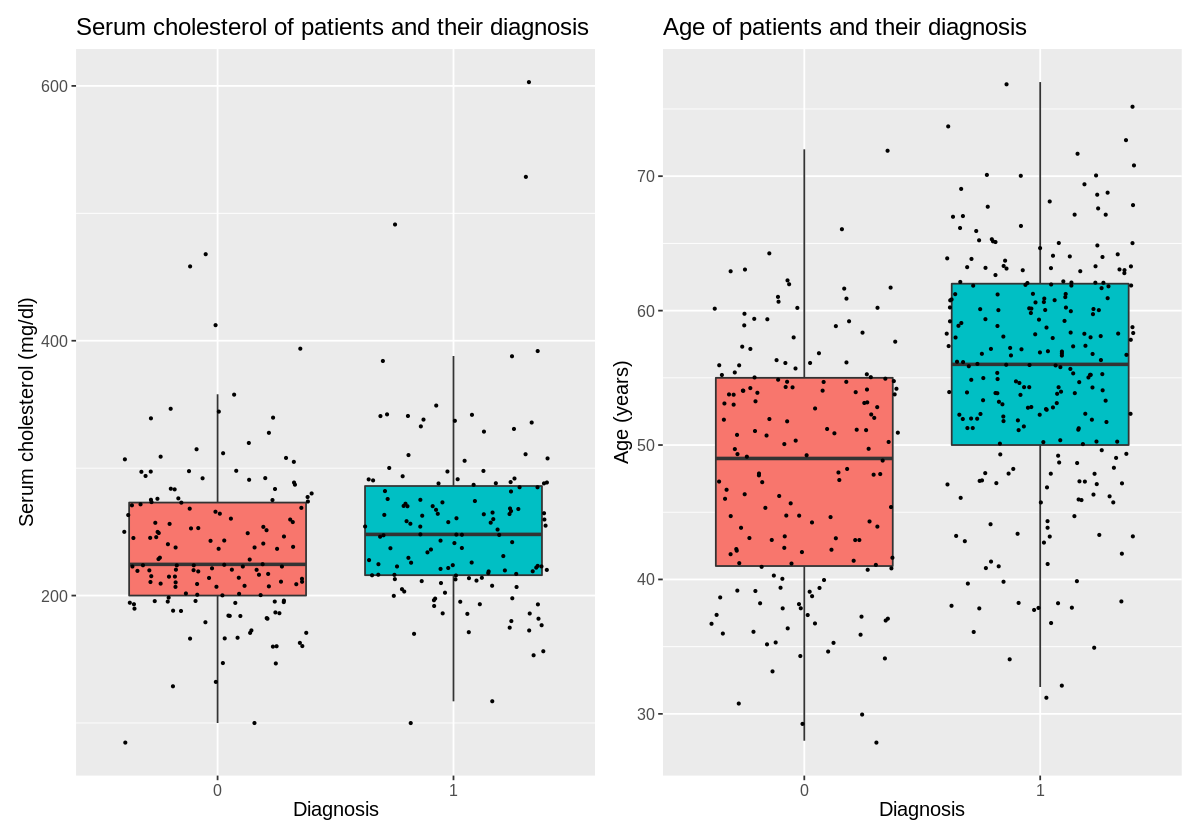

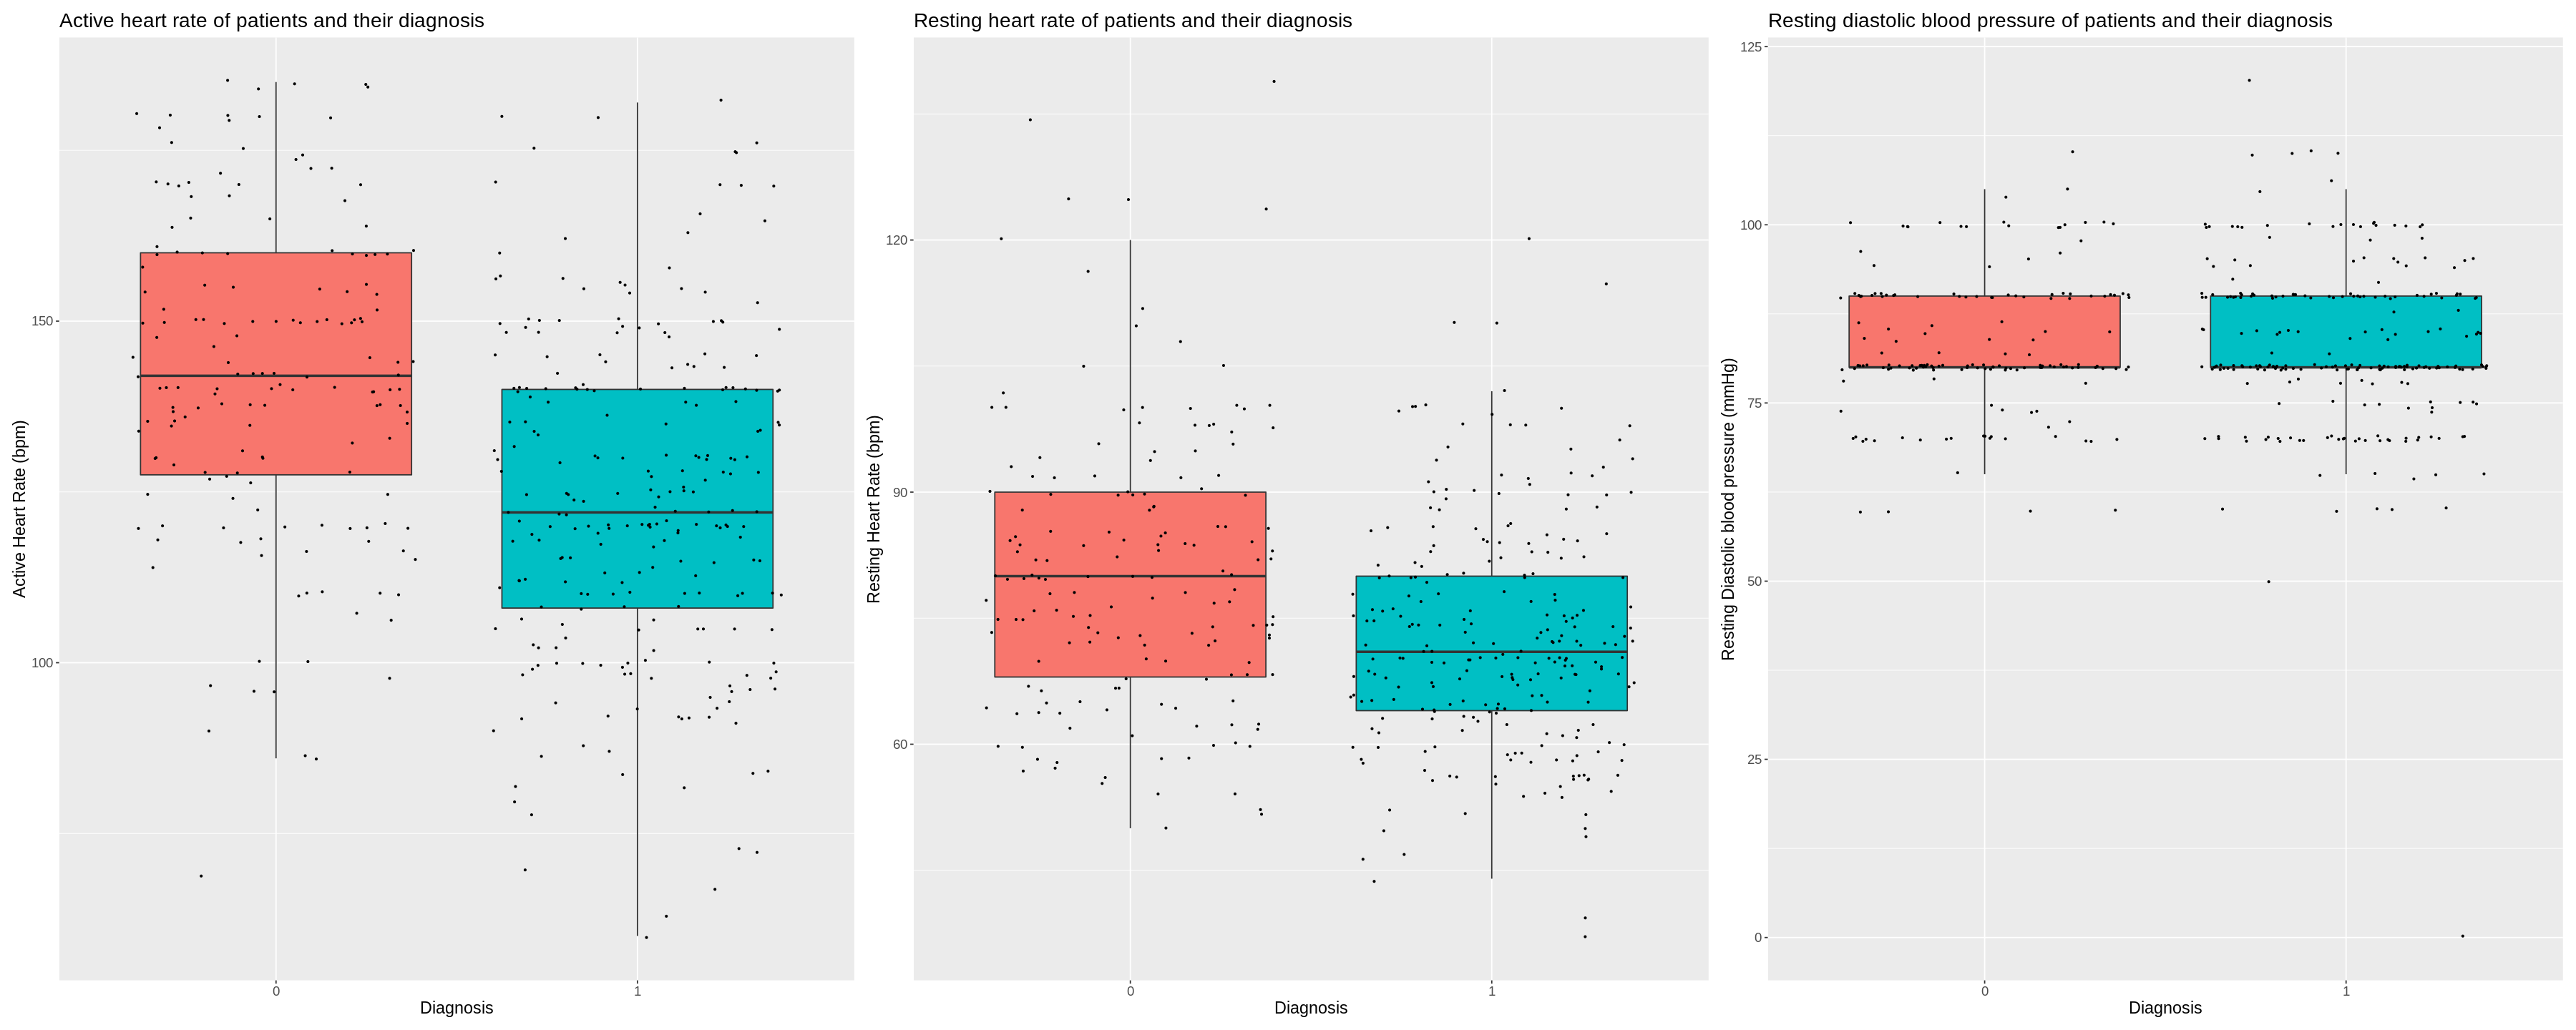

In [29]:
chol_plot <- heart_train |>
    filter(chol != 0) |>
    ggplot(aes(x = diagnosis, y = chol, fill = diagnosis)) +
        geom_boxplot(outlier.alpha = 0) +
        geom_jitter(color = "black", size = 0.5) +
        ggtitle("Serum cholesterol of patients and their diagnosis") +
        ylab("Serum cholesterol (mg/dl)") +
        xlab("Diagnosis") +
        theme(legend.position = 'none',
             text = element_text(size = 12)) 
# chol_plot

age_plot <- heart_train |>
    ggplot(aes(x = diagnosis, y = age, fill = diagnosis)) +
        geom_boxplot(outlier.alpha = 0) +
        geom_jitter(color = "black", size = 0.5) +
        ggtitle("Age of patients and their diagnosis") +
        ylab("Age (years)") +
        xlab("Diagnosis") +
        theme(legend.position = 'none',
             text = element_text(size = 12))
# age_plot

thalach_plot <- heart_train |>
    filter(thalach > 0) |>
    ggplot(aes(x = diagnosis, y = thalach, fill = diagnosis)) +
        geom_boxplot(outlier.alpha = 0) +
        geom_jitter(color = "black", size = 0.5) +
        ggtitle("Active heart rate of patients and their diagnosis") +
        ylab("Active Heart Rate (bpm)") +
        xlab("Diagnosis") +
        theme(legend.position = 'none',
             text = element_text(size = 14)) 
# thalach_plot

thalrest_plot <- heart_train |>
    ggplot(aes(x = diagnosis, y = thalrest, fill = diagnosis)) +
        geom_boxplot(outlier.alpha = 0) +
        geom_jitter(color = "black", size = 0.5) +
        ggtitle("Resting heart rate of patients and their diagnosis") +
        ylab("Resting Heart Rate (bpm)") +
        xlab("Diagnosis") +
        theme(legend.position = 'none',
             text = element_text(size = 14)) 
# thalrest_plot

trestbpd_plot <- heart_train |>
    ggplot(aes(x = diagnosis, y = trestbpd, fill = diagnosis)) +
        geom_boxplot(outlier.alpha = 0) +
        geom_jitter(color = "black", size = 0.5) +
        ggtitle("Resting diastolic blood pressure of patients and their diagnosis") +
        ylab("Resting Diastolic blood pressure (mmHg)") +
        xlab("Diagnosis") +
        theme(legend.position = 'none',
             text = element_text(size = 14)) 
# trestbpd_plot
options(repr.plot.width=10, repr.plot.height=7)
chol_plot + age_plot + plot_layout(widths = c(100, 100))
options(repr.plot.width=30, repr.plot.height=12)
thalach_plot + thalrest_plot + trestbpd_plot + plot_layout(widths = c(10, 10, 10))

Looking at the two graphs on the top, it could be seen that people diagnosed with heart condition has higher mean age and higher cholesterol mean readings than those don't. On the other hand, it's surprising to see that those with a heart condition has average lower active and resting heart rate. The mean blood pressure for both groups of people are similar which contradicts with what we expected. Except for the blood pressure graph, the data points are quite spread out as indicated visually and the expanded height of the box plots. This characteristic of the dataset will be taken into account during the data analysis.

## 2. Methods
We aim to create a highly accurate classification model. We will build a classification model for each factor that is easily measurable and significantly affects heart disease. These factors are age, sex, cholesterol, smoking, max heart rate, resting heart rate, and resting blood pressure. Then we choose three factors with the most accurate models to create our final model. To visualize each factor's accuracy, we will use a box plot. The final model percentage of false positives and false negatives will also be visualized. 

## 2.1 Classification Model

In [30]:
set.seed(1337) # Set seed for reproducility

all_recipe <- recipe(diagnosis ~ age + chol + thalach + thalrest + trestbpd, data = heart_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())


all_knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

all_heart_vfold <- vfold_cv(heart_train, v = 5, strata = diagnosis)
all_k_vals <- tibble(neighbors = seq(from = 31, to = 61, by = 4))


all_knn_results <- workflow() |>
    add_recipe(all_recipe) |>
    add_model(all_knn_spec) |>
    tune_grid(resamples = all_heart_vfold, grid = all_k_vals) |>
    collect_metrics()
    
all_accuracy <- all_knn_results |>
    filter(.metric == "accuracy")

all_kvalue <- all_accuracy |> filter(mean == max(mean)) 

all_kvalue$neighbors
all_kvalue$mean


[1] 47

[1] 0.7570875

In [36]:
getKPlot <- function(accuracy_df) {
    plot <- accuracy_df |>
        ggplot(aes(x = neighbors, y = mean)) +
        geom_point() +
        geom_line() +
        labs(x = "K values", y = "Accuracy (in %)") +
        ggtitle("Accuracy vs. K values") +
        theme(text = element_text(size = 25))
    return(plot)
}

In order to prevent code repition, the function `getKPlot()` is defined to make a plot of Accuracy vs. K-values for a given accuracy data frame.

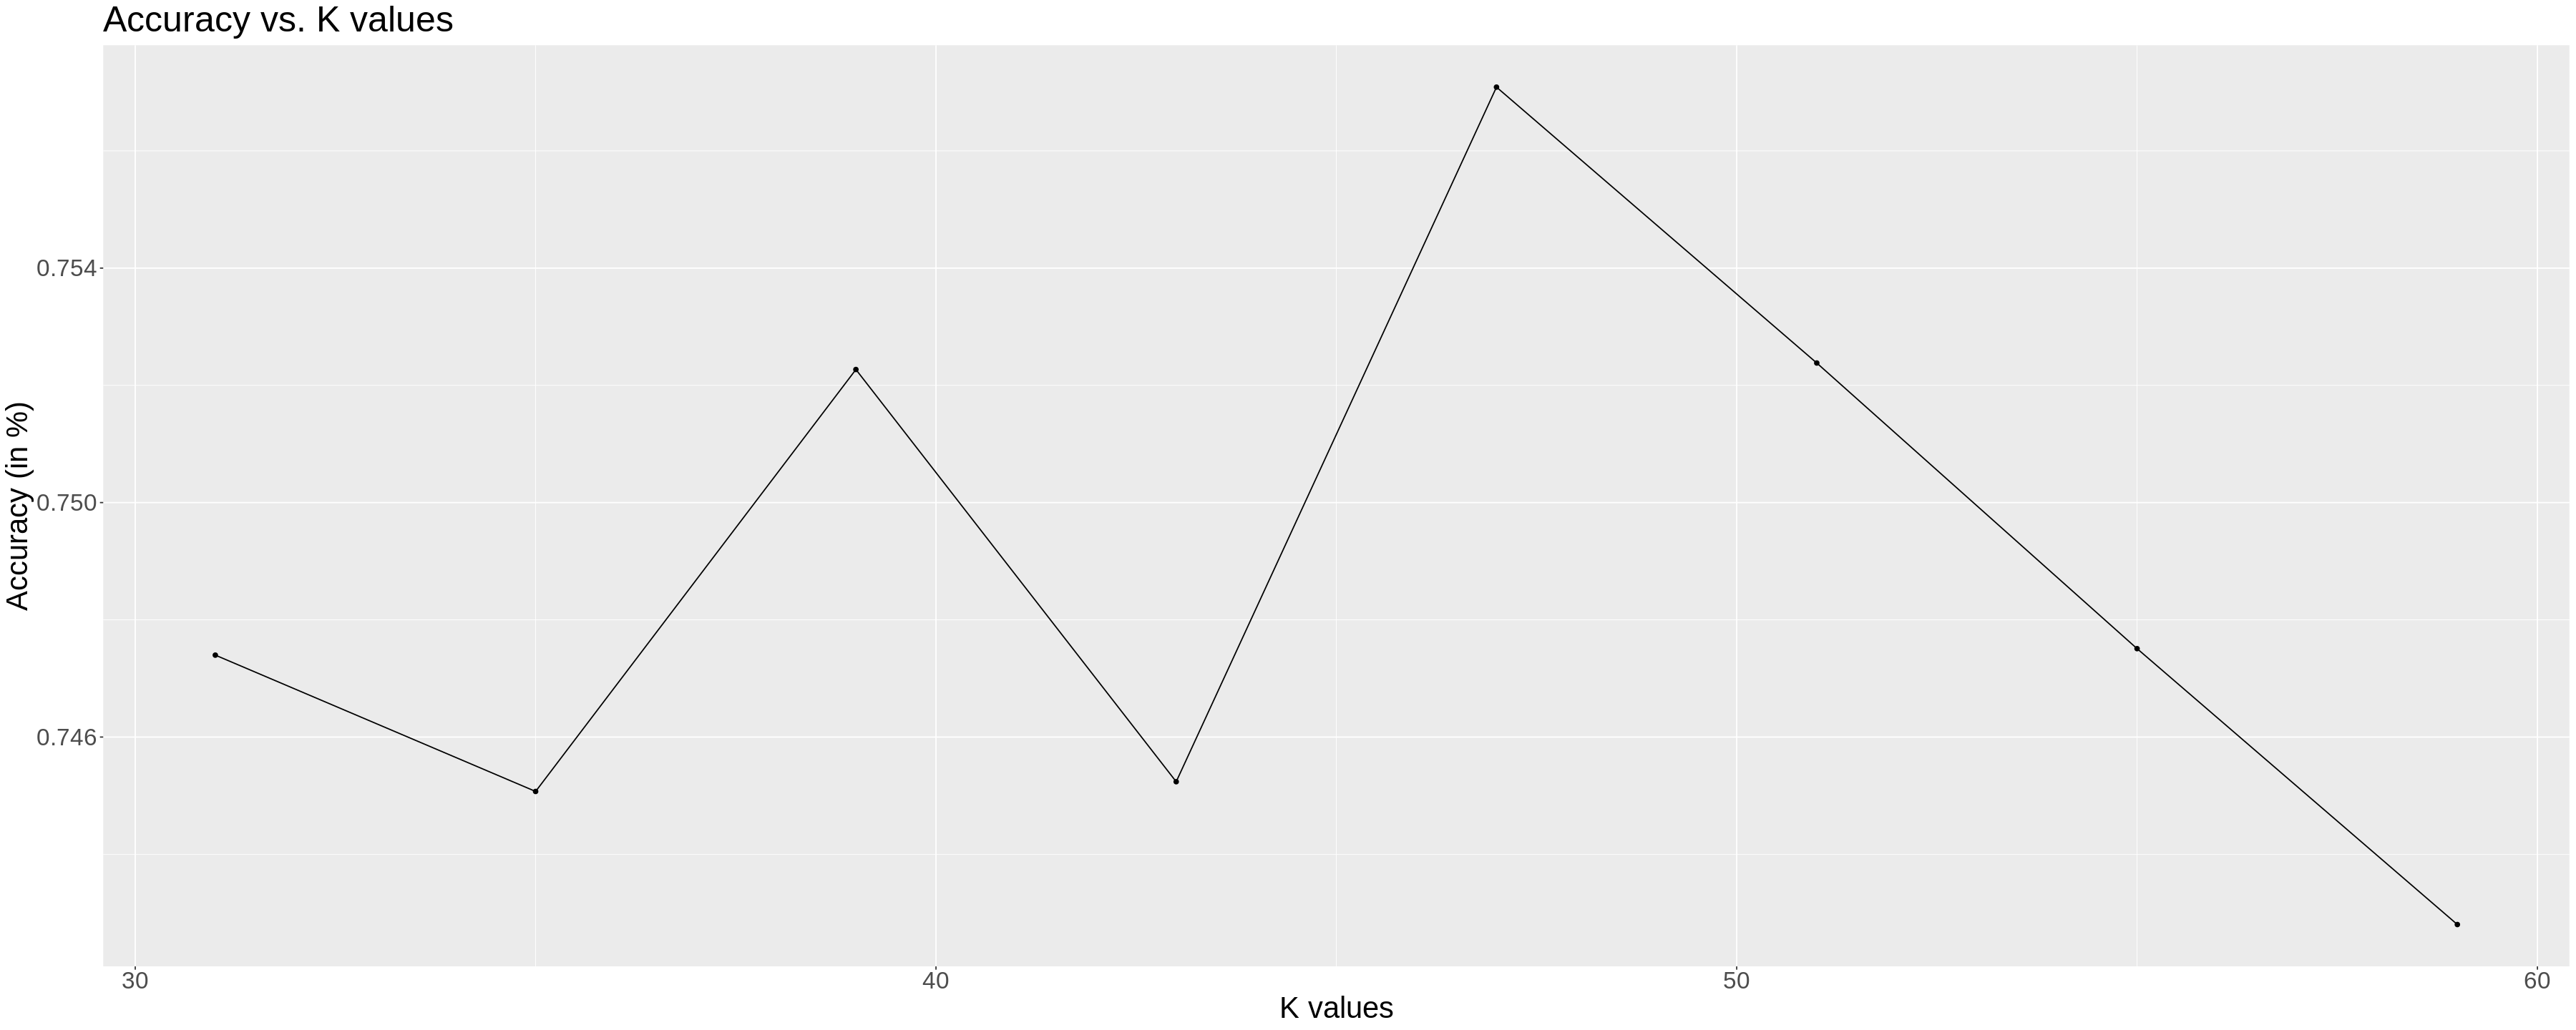

In [39]:
# Plotting K-plot for all-predictors model
all_kval_plot <- getKPlot(all_accuracy)
all_kval_plot

In [40]:
set.seed(1337) # Set seed for reproducility

notrestbpd_recipe <- recipe(diagnosis ~ age + chol + thalach + thalrest, data = heart_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())


notrestbpd_knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

notrestbpd_heart_vfold <- vfold_cv(heart_train, v = 5, strata = diagnosis)
notrestbpd_k_vals <- tibble(neighbors = seq(from = 31, to = 61, by = 4))


notrestbpd_knn_results <- workflow() |>
    add_recipe(notrestbpd_recipe) |>
    add_model(notrestbpd_knn_spec) |>
    tune_grid(resamples = notrestbpd_heart_vfold, grid = notrestbpd_k_vals) |>
    collect_metrics()
    
notrestbpd_accuracy <- notrestbpd_knn_results |>
    filter(.metric == "accuracy")

notrestbpd_kvalue <- notrestbpd_accuracy |> filter(mean == max(mean)) 

notrestbpd_kvalue$neighbors
notrestbpd_kvalue$mean

[1] 55

[1] 0.7662237

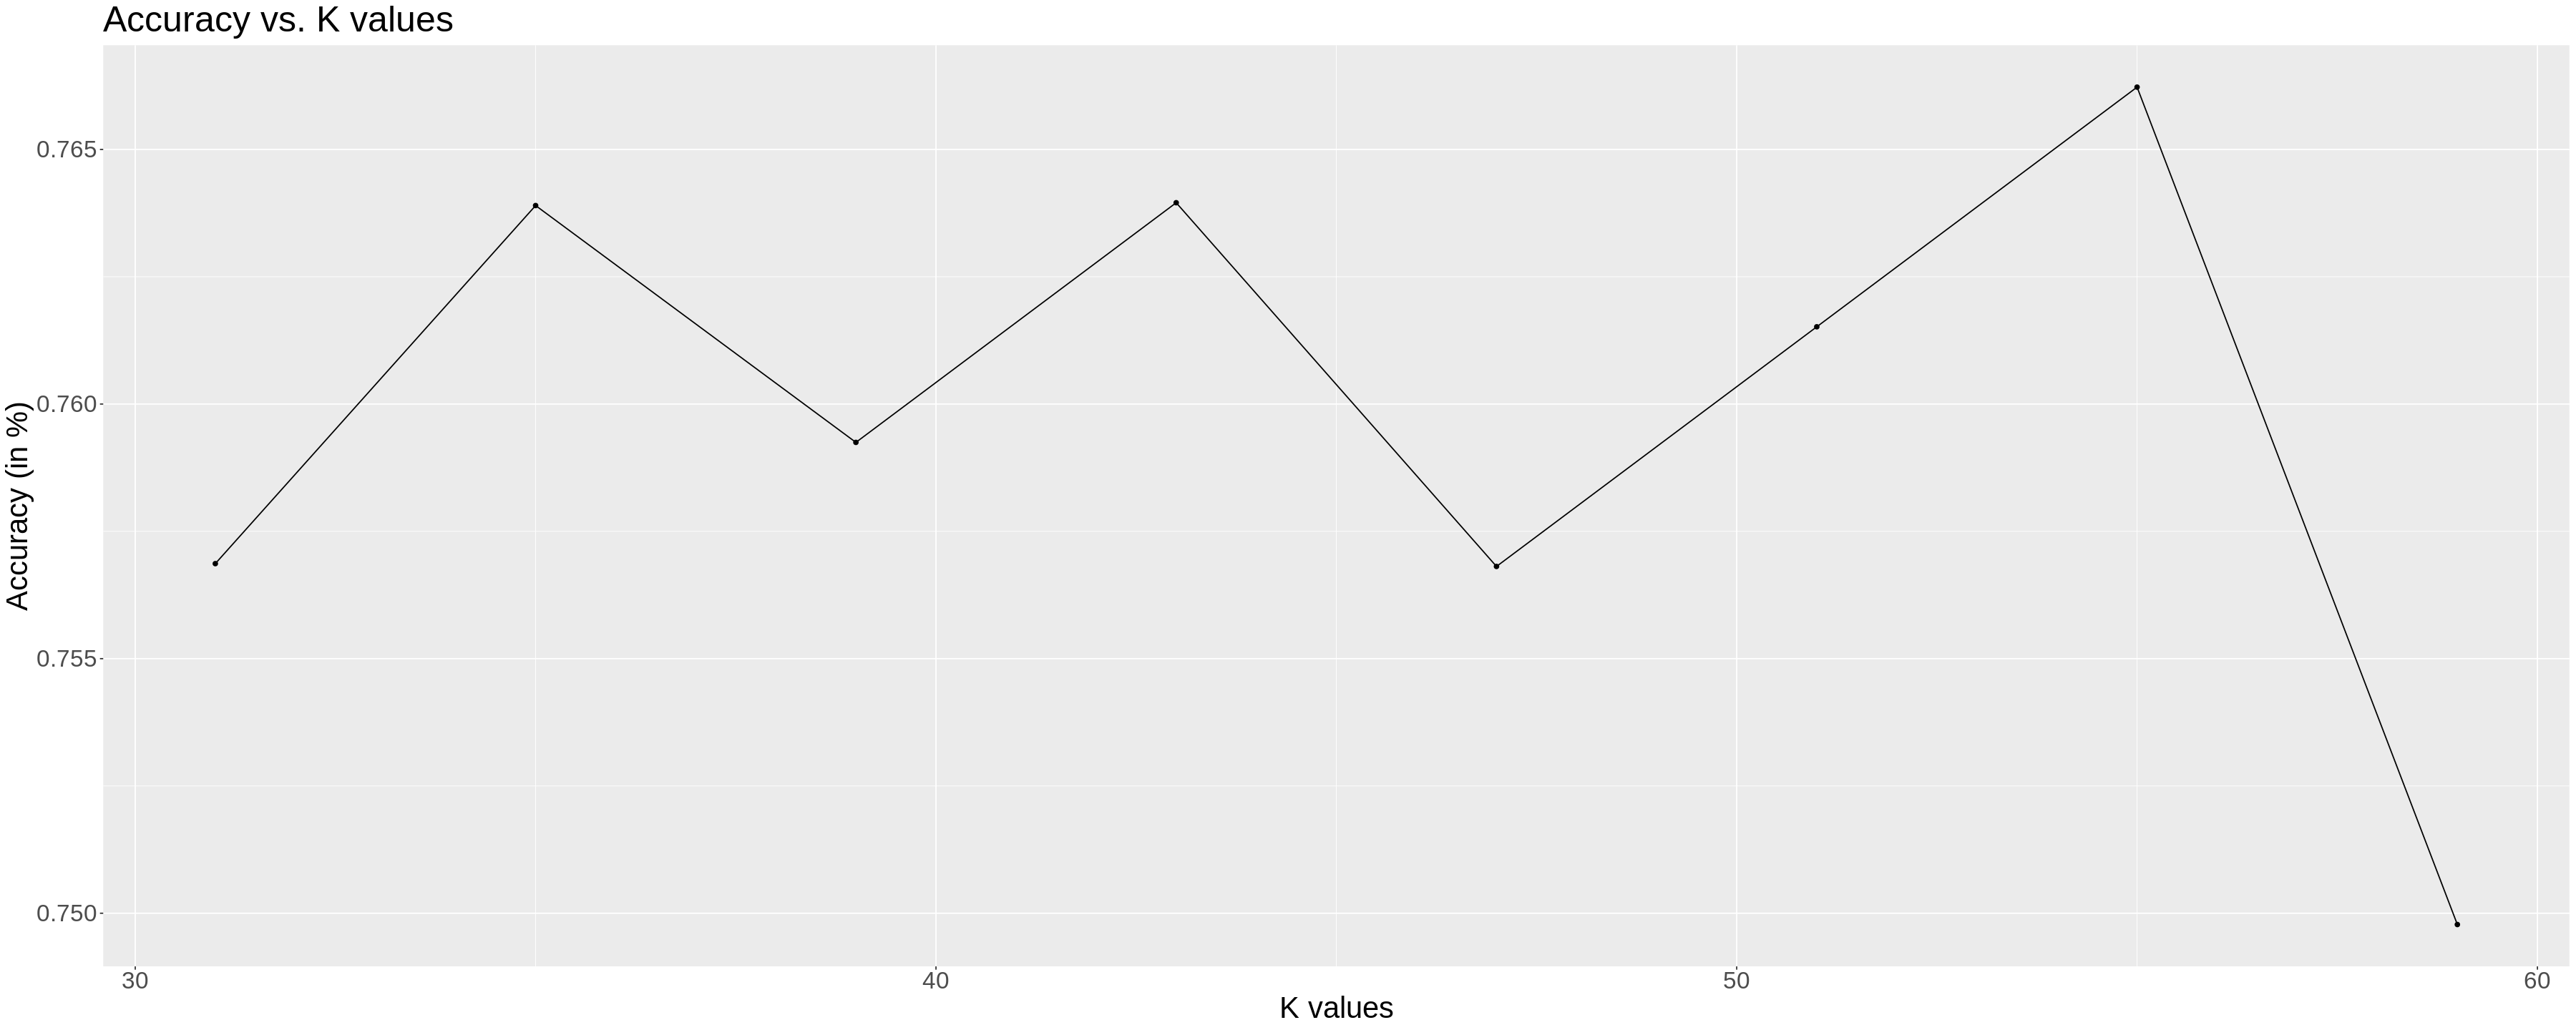

In [42]:
notrestbpd_plot <- getKPlot(notrestbpd_accuracy)
notrestbpd_plot

In [43]:
set.seed(1337) # Set seed for reproducility

nobpd_chol_recipe <- recipe(diagnosis ~ age + thalach + thalrest, data = heart_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())


nobpd_chol_knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

nobpd_chol_heart_vfold <- vfold_cv(heart_train, v = 5, strata = diagnosis)
nobpd_chol_k_vals <- tibble(neighbors = seq(from = 31, to = 61, by = 4))


nobpd_chol_knn_results <- workflow() |>
    add_recipe(nobpd_chol_recipe) |>
    add_model(nobpd_chol_knn_spec) |>
    tune_grid(resamples = nobpd_chol_heart_vfold, grid = nobpd_chol_k_vals) |>
    collect_metrics()
    
nobpd_chol_accuracy <- nobpd_chol_knn_results |>
    filter(.metric == "accuracy")

nobpd_chol_kvalue <- nobpd_chol_accuracy |> filter(mean == max(mean)) 

nobpd_chol_kvalue$neighbors
nobpd_chol_kvalue$mean

[1] 51

[1] 0.7076966

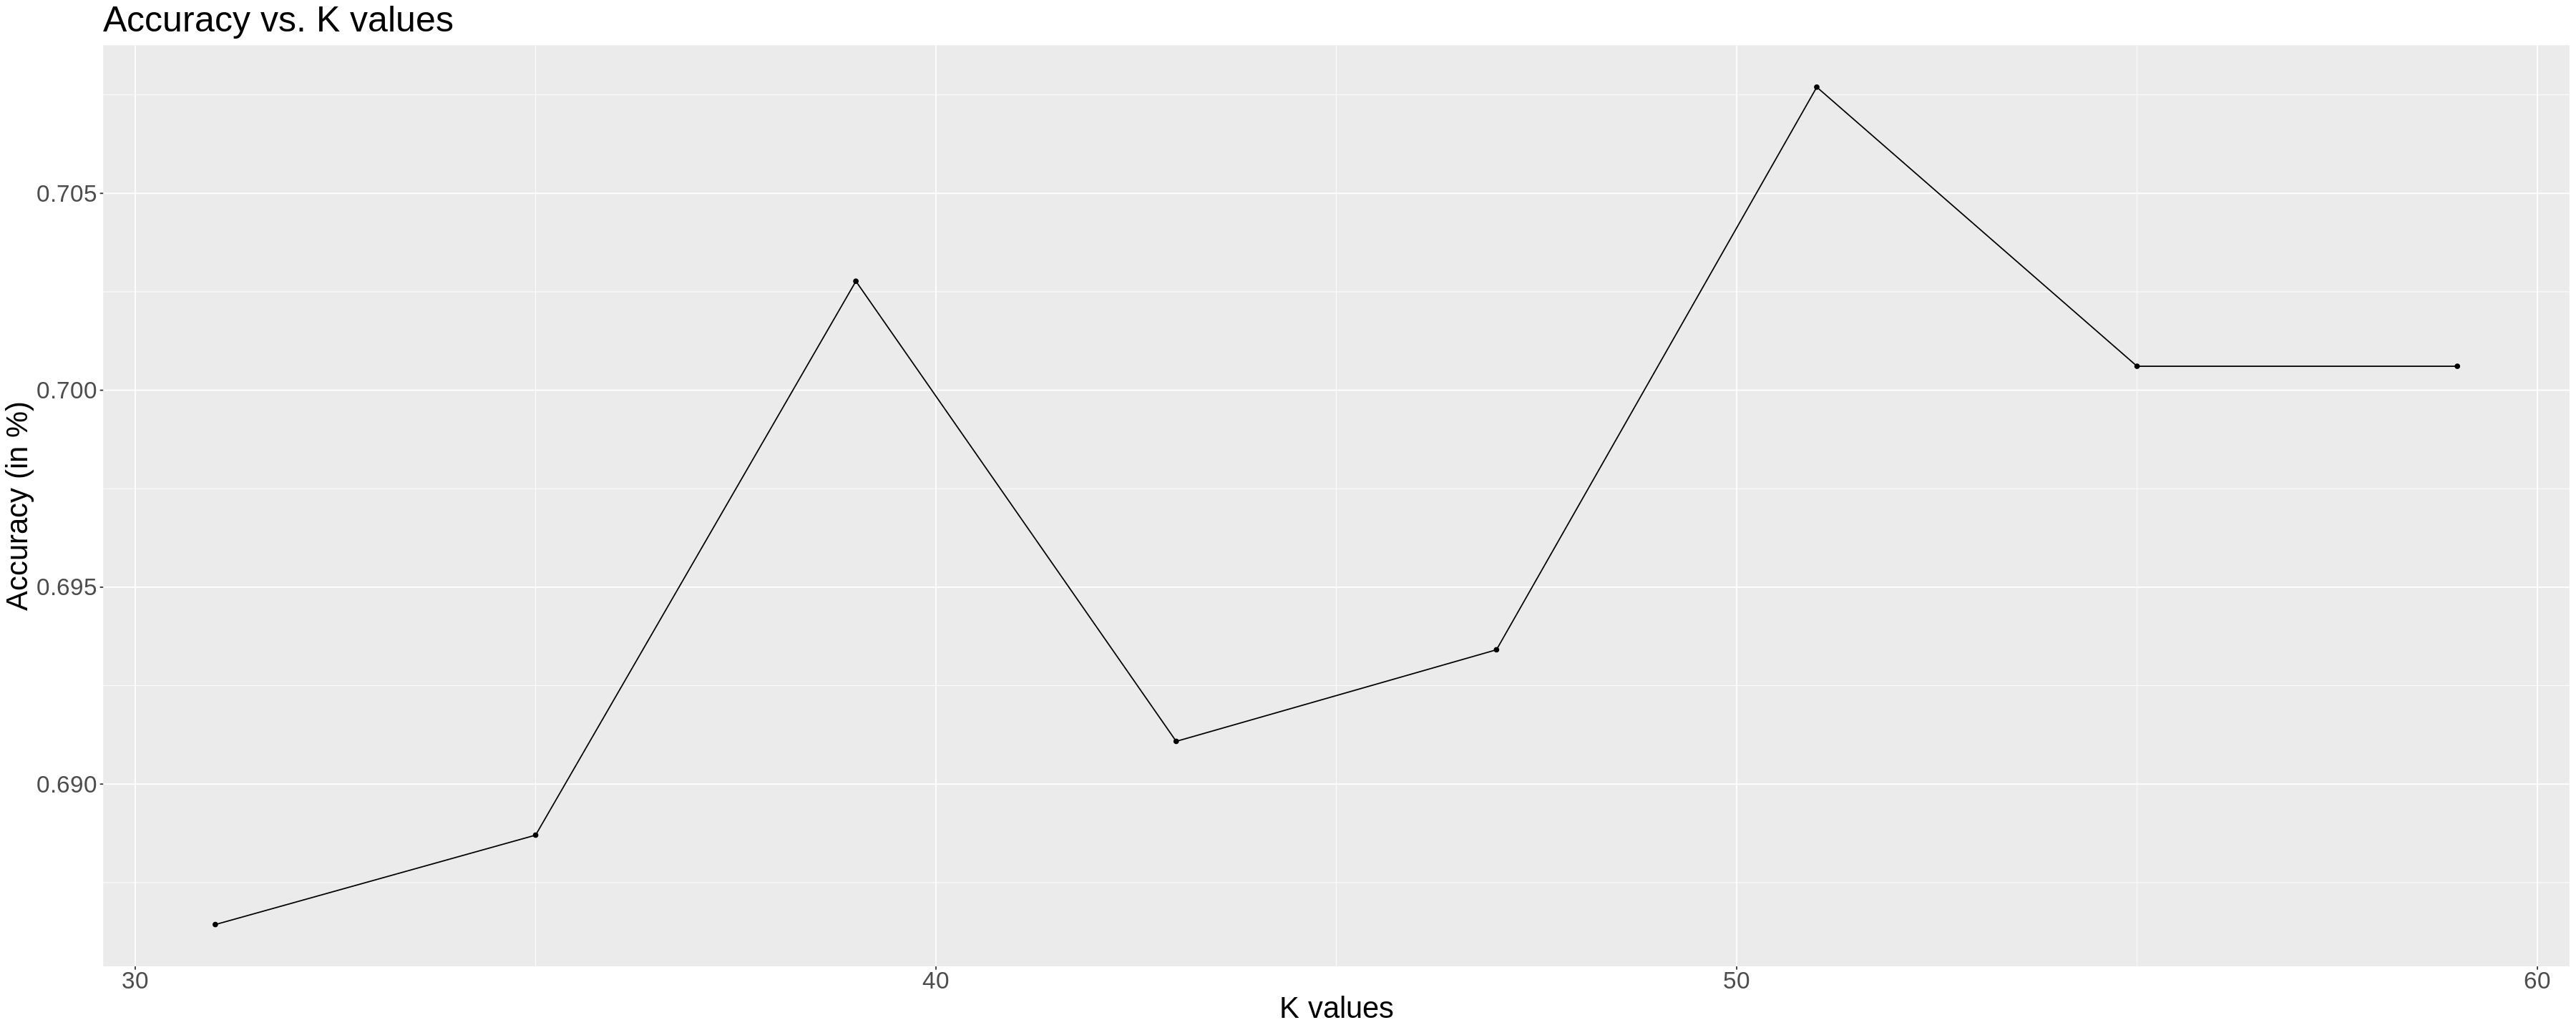

In [44]:
nobpd_chol_plot <- getKPlot(nobpd_chol_accuracy)
nobpd_chol_plot

In [46]:
#Testing K value of best model: All except trestbpd

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 55) |>
  set_engine("kknn") |>
  set_mode("classification")

knn_fit <- workflow() |>
  add_recipe(notrestbpd_recipe) |>
  add_model(knn_spec) |>
  fit(data = heart_train)

heart_test_predictions <- predict(knn_fit, heart_test) |>
  bind_cols(heart_test) 
  
heart_accuracy <- heart_test_predictions |>
    metrics(truth = diagnosis, estimate = .pred_class) |>
    filter(.metric == "accuracy")


confusion <- heart_test_predictions |>
             conf_mat(truth = diagnosis, estimate = .pred_class)
confusion

          Truth
Prediction  0  1
         0 26 19
         1 16 46

## 2.3 Visualization of Classification Model

First, we need to convert the confusion matrix to a dataframe and calculate the percentage for: true positive, true negative, false positive and false negative.

In [90]:
# Convert confusion matrix to a dataframe
confusion_df <- as.data.frame(confusion$table) |>
    mutate(Percentage = Freq / sum(Freq))
confusion_df

Prediction,Truth,Freq,Percentage
<fct>,<fct>,<dbl>,<dbl>
0,0,26,0.2429907
1,0,16,0.1495327
0,1,19,0.1775701
1,1,46,0.4299065


Next, we will use heatmap to depict the percentage of the following:

    - True positive - when the prediction and the truth are both 1
    - True negative - when the prediction and the truth are both 0
    - False positive - when the prediction is 1 and the truth is 0
    - False negative - when the prediction is 0 and the truth is 1

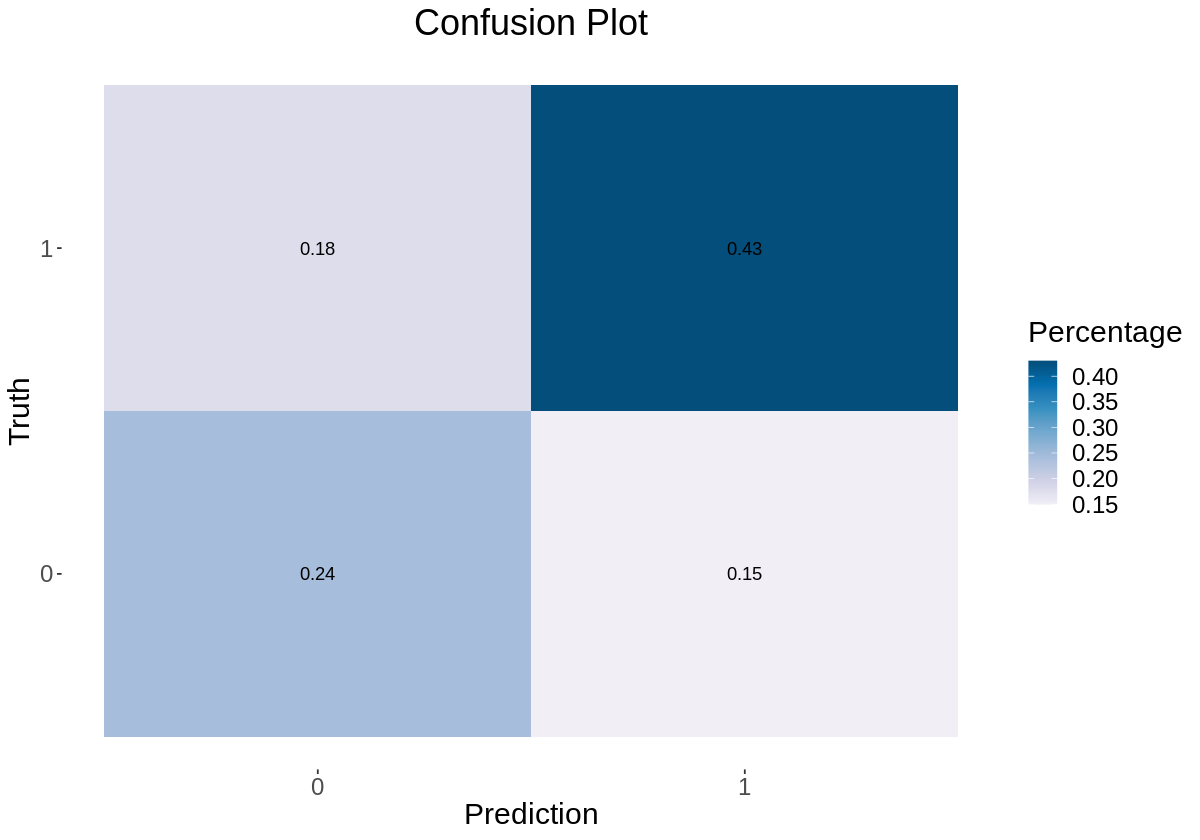

In [125]:
confusion_plot <- confusion_df |>
    ggplot(aes(x = Prediction, y = Truth, fill = Percentage)) +
    geom_tile() +
    geom_text(aes(label = round(Percentage, 2))) +
    scale_fill_distiller(palette = "PuBu", direction = 1) +
    theme_bw() +
    theme(panel.border = element_blank(), panel.grid.major = element_blank(), 
          panel.grid.minor = element_blank()) +
    theme(text = element_text(size = 18), plot.title = element_text(hjust = 0.5)) +
    ggtitle("Confusion Plot")
confusion_plot

## 3. Discussion 

## 4. Expected Outcome and Significance
Heart disease is the leading cause of death around the globe, with 19.05 million global deaths in 2020. Through this project, we expect to find and assess the significant factors contributing to an individual’s chances of being diagnosed with heart disease. Specifically, we are asking what combinations of factors correlate with this health complication. From the initial visualization of the five factors, we expect the two main factors of heart disease to be age and serum cholesterol concentration. This project will emphasize factors that individuals can independently change. For instance, high serum cholesterol can be under control with a healthy lifestyle. This project aims to educate individuals on which lifestyle choices lower the chances of heart disease.

## References
Public Health Agency of Canada. (2018). Report from the Canadian Chronic Disease Surveillance System: Heart Disease in Canada, 2018. Retrieved from the Government of Canada website: https://www.canada.ca/content/dam/phac-aspc/documents/services/publications/diseases-conditions/report-heart-disease-canada-2018/pub1-eng.pdf

Olvera Lopez E, Ballard BD, Jan A. Cardiovascular Disease. [Updated 2022 Aug 8]. In: StatPearls [Internet]. Treasure Island (FL): StatPearls Publishing; 2022 Jan-. Available from: https://www.ncbi.nlm.nih.gov/books/NBK535419/

Advocate , H. (2023). Ischemic heart disease: Advocate health care. Advocate Health. Retrieved March 10, 2023, from https://www.advocatehealth.com/health-services/advocate-heart-institute/conditions/ischemic-heart-disease#:~:text=Ischemic%20heart%20disease%20refers%20to,cardiac%20ischemia%20or%20ischemic%20cardiomyopathy.

Center for Disease Control and Prevention. (2020, April 21). Prevent heart disease. Centers for Disease Control and Prevention. Retrieved March 10, 2023, from https://www.cdc.gov/heartdisease/prevention.htm#print